In [35]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import math


# Resedual connection

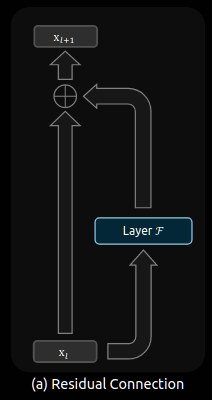

In [36]:
class ResConnection(nn.Module):
  def __init__(self,f,n):
    super(ResConnection,self).__init__()
    self.f = f
    self.n = n
  def forward(self,x):
    return self.f(x) + x

In [37]:
n = 6
f = nn.Linear(n,n)

resedual_connection = ResConnection(f=f,n=n)

x = torch.rand(n)


print(x)
resedual_connection.forward(x=x)

tensor([0.6317, 0.4157, 0.4709, 0.2629, 0.7077, 0.4269])


tensor([ 0.5383, -0.0241,  0.0832,  0.0515,  0.4553,  0.2129],
       grad_fn=<AddBackward0>)

# Hypere connection

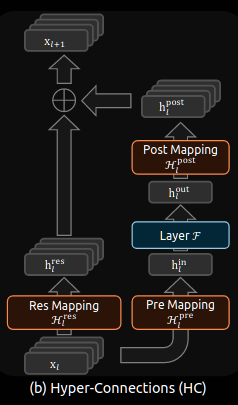

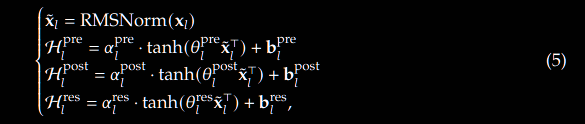

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HyperConnection(nn.Module):
    def __init__(self, f, n, dim):
        super(HyperConnection, self).__init__()
        self.f = f
        self.dim = dim
        self.n = n

        self.alph_pre = nn.Parameter(torch.ones(1) * 0.01)
        self.alph_post = nn.Parameter(torch.ones(1) * 0.01)
        self.alph_res = nn.Parameter(torch.ones(1) * 0.01)

        self.beta_pre = nn.Parameter(torch.zeros(1, n))
        self.beta_post = nn.Parameter(torch.zeros(1, n))
        self.beta_res = nn.Parameter(torch.zeros(1, n))

        self.theta_pre = nn.Parameter(torch.rand(n, dim))
        self.theta_post = nn.Parameter(torch.rand(n, dim))
        self.theta_res = nn.Parameter(torch.rand(n, dim))

    def forward(self, x):
        x_norm = F.rms_norm(x, (self.dim,))

        h_pre_map = self.alph_pre * torch.tanh(F.linear(x_norm, self.theta_pre)) + self.beta_pre
        h_res_map = self.alph_res * torch.tanh(F.linear(x_norm, self.theta_res)) + self.beta_res
        h_post_map = self.alph_post * torch.tanh(F.linear(x_norm, self.theta_post)) + self.beta_post

        h_in = h_pre_map * x
        h_out = self.f(h_in)
        h_post = h_post_map * h_out

        h_res = h_res_map * x

        return h_res + h_post

In [39]:
n = 8
f = nn.Linear(n,n)

resedual_connection = HyperConnection(f=f,n=n,dim=8)

x = torch.rand(n)


print(x)
resedual_connection.forward(x=x)

tensor([0.2833, 0.9056, 0.8643, 0.9987, 0.0818, 0.8422, 0.9674, 0.6242])


tensor([[0.0018, 0.0079, 0.0112, 0.0089, 0.0025, 0.0084, 0.0105, 0.0086]],
       grad_fn=<AddBackward0>)

# Manifold-Constrained Hyper-Connections

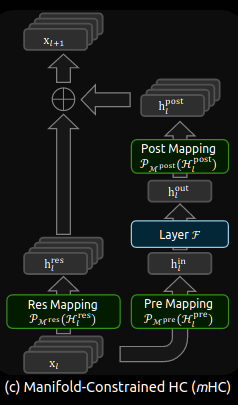

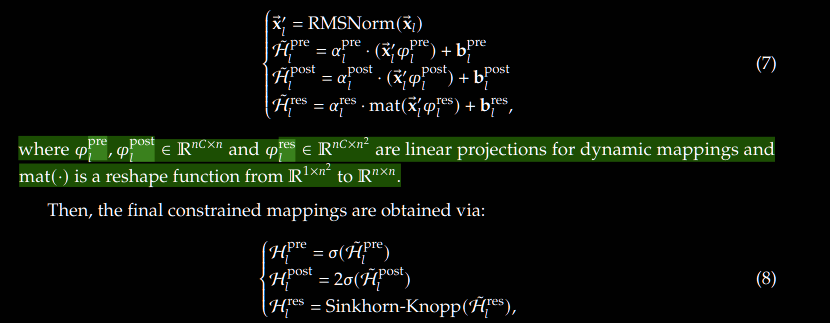

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ManifoldConstrainedHyperConnection(nn.Module):
    def __init__(self, f, n, dim):
        super().__init__()
        self.f = f
        self.n = n
        self.dim = dim

        self.phi_pre = nn.Parameter(torch.randn(n, dim) * 0.02)
        self.phi_post = nn.Parameter(torch.randn(n, dim) * 0.02)
        self.phi_res = nn.Parameter(torch.randn(n * n, dim) * 0.02)

        self.alph_pre = nn.Parameter(torch.ones(1) * 0.01)
        self.alph_post = nn.Parameter(torch.ones(1) * 0.01)
        self.alph_res = nn.Parameter(torch.ones(1) * 0.01)

        self.beta_pre = nn.Parameter(torch.zeros(n))
        self.beta_post = nn.Parameter(torch.zeros(n))
        self.beta_res = nn.Parameter(torch.zeros(n, n))

    def forward(self, x):
        x_norm = F.rms_norm(x, (self.dim,))

        h_tilde_pre = self.alph_pre * F.linear(x_norm, self.phi_pre) + self.beta_pre
        h_tilde_post = self.alph_post * F.linear(x_norm, self.phi_post) + self.beta_post

        res_flat = self.alph_res * F.linear(x_norm, self.phi_res)
        h_tilde_res = res_flat.view(-1, self.n, self.n) + self.beta_res

        h_map_pre = torch.sigmoid(h_tilde_pre)
        h_map_post = 2 * torch.sigmoid(h_tilde_post)
        h_map_res = self.sinkhorn_knopp(h_tilde_res)


        h_in = h_map_pre * x
        h_out = self.f(h_in)

        h_post = h_map_post * h_out

        h_res = torch.bmm(h_map_res, x.unsqueeze(-1)).squeeze(-1)

        return h_res + h_post

    def sinkhorn_knopp(self, A, iterations=3):
        M = torch.exp(A)
        for _ in range(iterations):
            M = M / M.sum(dim=-1, keepdim=True)
            M = M / M.sum(dim=-2, keepdim=True)
        return M

In [40]:
n = 8
f = nn.Linear(n,n)

resedual_connection = HyperConnection(f=f,n=n,dim=8)

x = torch.rand(n)


print(x)
resedual_connection.forward(x=x)

tensor([0.9629, 0.8525, 0.7517, 0.1200, 0.9366, 0.6476, 0.1867, 0.4041])


tensor([[0.0062, 0.0052, 0.0092, 0.0027, 0.0103, 0.0050, 0.0046, 0.0033]],
       grad_fn=<AddBackward0>)